<a href="https://colab.research.google.com/github/ulanserikuly/Finding-Similar-Items/blob/main/Finding_similar_items.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Finding similar items


The task is to implement a detector of pairs of similar book reviews.

### Installation and import of libraries

In [ ]:
!pip install kaggle datasketch -q

import pandas as pd
import numpy as np
import os
import re
import html
import json
import time
from collections import defaultdict
import matplotlib.pyplot as plt
from datasketch import MinHash, MinHashLSH

### Configuring Kaggle API

In [ ]:
from google.colab import files

uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading dataset

The Amazon Books Reviews dataset is hosted on Kaggle and requires authentication, API key information is in uploaded file.

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

api.dataset_download_files(
    dataset='mohamedbakhet/amazon-books-reviews',
    path='.',
    unzip=True,
    quiet=False
)

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews


100%|██████████| 1.06G/1.06G [00:05<00:00, 217MB/s]


### Loading and exploring of the dataset

It is needed to load a sample of the dataset and perform basic exploratory analysis on a sample to understand dataset. Exploring whole dataset takes too much time and processing power, that's why it was decided to perform analysis on a sample.

In [ ]:
USE_SAMPLE = True
SAMPLE_SIZE = 50000
np.random.seed(42) # it was decided to choose random but reproducible sample

if USE_SAMPLE:
    n_total = 3000000
    df = pd.read_csv(
        "Books_rating.csv",
        skiprows=lambda i: i > 0 and np.random.random() > (SAMPLE_SIZE / n_total)
    ).head(SAMPLE_SIZE)
else:
    df = pd.read_csv("Books_rating.csv")

In [ ]:
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1858683092,Mensa Number Puzzles (Mensa Word Games for Kids),NaN,A1AYN4J7T43M11,"""dirtpile""",4/4,3.0,981417600,Made me wish I was Einstein.,Not much I can say about this book... It's ful...
1,0789480662,Eyewitness Travel Guide to Europe,NaN,A1CEJFXSJYQBTX,"J. Hauser ""Yellow Page Expert""",3/3,5.0,1157241600,The Travelers Companion,I admit it: I'm addicted to travel. My wife an...
2,3161453549,Homer or Moses?: Early Christian Interpretatio...,97.5,A2VMAQ4SPK1DRX,"""poetauthorscholar""",1/14,1.0,1061251200,It was published. That's an accomplishment.,"First, this text is not the source of the inte..."
3,B0006WHSNE,Mini-mysteries,NaN,A2ZO0WE12GATPW,A. J. Arndt,0/0,5.0,1194048000,One of my favorite books.,I bought this book when I was a kid. I've lost...
4,0373271816,By Honor Bound (The Lassiter Law) (Silhouette ...,NaN,A1TCDS9S2NIVPB,"C. Penn ""WordWeaving""",6/6,4.0,1007510400,Highly recommended,Security specialist Micah Lassiter finds himse...


In [ ]:
# dataset information
print(f"Reviews loaded: {len(df)}")
print(f"Columns: {', '.join(df.columns.tolist())}")
print(f"Unique books: {df['Title'].nunique()}")
print(f"Unique users: {df['User_id'].nunique()}")

# check for missing values
null_count = df['review/text'].isnull().sum()
print(f"Missing review text: {null_count}")

avg_length = df['review/text'].dropna().str.split().str.len().mean()
print(f"Average review length: {avg_length:.2f} words")

print(f"\nRating Distribution:")
print(df['review/score'].value_counts().sort_index().to_string())

Reviews loaded: 50000
Columns: Id, Title, Price, User_id, profileName, review/helpfulness, review/score, review/time, review/summary, review/text
Unique books: 24285
Unique users: 35350
Missing review text: 0
Average review length: 143.38 words

Rating Distribution:
review/score
1.0     3369
2.0     2557
3.0     4261
4.0     9677
5.0    30136


### Text preprocessing

In this step cleaning of the dataset was performed in order to increase quality of the exploring data for further research.

Text was cleaned by converting to lowercase, removing special characters, and filtering stopwords. It was decided to keep only reviews with at least 5 meaningful words, remove duplicates only when text, title, and user are all identical.

In [ ]:
# select columns to work with
df_working = df[['review/text', 'Title', 'User_id']].copy()

df_working = df_working.dropna(subset=['review/text'])

def clean_text(text):
    if pd.isna(text):
        return ""
    text = html.unescape(str(text))
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_working['cleaned_text'] = df_working['review/text'].apply(clean_text)
df_working = df_working[df_working['cleaned_text'].str.len() > 0].reset_index(drop=True)
print(f"After cleaning: {len(df_working)}")

After cleaning: 50000


In [ ]:
df_working.head()

,review/text,Title,User_id,cleaned_text
0,Not much I can say about this book... It's ful...,Mensa Number Puzzles (Mensa Word Games for Kids),A1AYN4J7T43M11,not much i can say about this book it s full o...
1,I admit it: I'm addicted to travel. My wife an...,Eyewitness Travel Guide to Europe,A1CEJFXSJYQBTX,i admit it i m addicted to travel my wife and ...
2,"First, this text is not the source of the inte...",Homer or Moses?: Early Christian Interpretatio...,A2VMAQ4SPK1DRX,first this text is not the source of the inter...
3,I bought this book when I was a kid. I've lost...,Mini-mysteries,A2ZO0WE12GATPW,i bought this book when i was a kid i ve lost ...
4,Security specialist Micah Lassiter finds himse...,By Honor Bound (The Lassiter Law) (Silhouette ...,A1TCDS9S2NIVPB,security specialist micah lassiter finds himse...


In [ ]:
stopwords = {
    'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
    'of', 'with', 'by', 'from', 'is', 'was', 'are', 'were', 'been', 'be',
    'this', 'that', 'it', 'i', 'you', 'he', 'she', 'we', 'they'
}

def remove_stopwords(text):
    words = text.split()
    return ' '.join([w for w in words if w not in stopwords])

df_working['cleaned_text'] = df_working['cleaned_text'].apply(remove_stopwords)
#Filter short reviews
df_working = df_working[df_working['cleaned_text'].str.split().str.len() >= 5].reset_index(drop=True)

It was decided to filter out short reviews, because if the review after stopwords removal is less that 5 words, it can't create 3-word shingles, which will further break algorithm, because of the empty shingle set.
if review = 4 words => number of shingles = 4 - 3 + 1 = 2 < 3
<br>

Problems with 2-word shingle like 'great book' could be:
 * Too generic, no meaningful similarity signal
 * High false positive rate, many reviews will say "great book"
 * Not useful for duplicate detection, substantial text overlap is more preferred

In [ ]:
df_working.head()

,review/text,Title,User_id,cleaned_text
0,Not much I can say about this book... It's ful...,Mensa Number Puzzles (Mensa Word Games for Kids),A1AYN4J7T43M11,not much can say about book s full vvvery diff...
1,I admit it: I'm addicted to travel. My wife an...,Eyewitness Travel Guide to Europe,A1CEJFXSJYQBTX,admit m addicted travel my wife semi retired g...
2,"First, this text is not the source of the inte...",Homer or Moses?: Early Christian Interpretatio...,A2VMAQ4SPK1DRX,first text not source interrelation between me...
3,I bought this book when I was a kid. I've lost...,Mini-mysteries,A2ZO0WE12GATPW,bought book when kid ve lost track how many ti...
4,Security specialist Micah Lassiter finds himse...,By Honor Bound (The Lassiter Law) (Silhouette ...,A1TCDS9S2NIVPB,security specialist micah lassiter finds himse...


In [ ]:
# remove exact duplicates only when all 3 columns match
initial_count = len(df_working)
df_working = df_working.drop_duplicates(subset=['cleaned_text', 'Title', 'User_id']).reset_index(drop=True)
duplicates_removed = initial_count - len(df_working)

print(f"Exact duplicates removed (same text + title + user): {duplicates_removed}")
print(f"Final preprocessed reviews: {len(df_working)}")
print(f"Average words per review: {df_working['cleaned_text'].str.split().str.len().mean():.2f}")

same_text_diff_meta = df_working.duplicated(subset=['cleaned_text'], keep=False).sum()

Exact duplicates removed (same text + title + user): 215
Final preprocessed reviews: 49744
Average words per review: 96.87


In [ ]:
print(same_text_diff_meta)

1301


1301 reviews have identical text but different title/user.

In [ ]:
df_working['doc_id'] = range(len(df_working))

Similarity calculation uses only review/text. Title and User_id are retained for analysis purposes only.

### Shingles creation

We convert each review into a set of k-word shingles (k = 3). K = 3 provides a good balance between specificity and generalization for review text.

Number of shingles = Number of words - k + 1
<br>

Example:
* 'great book highly recommend everyone' -> 'great book highly', 'book highly recommend', 'highly recommend everyone'

In [ ]:
def create_shingles(text, k=3):
    words = text.split()
    if len(words) < k:
        return {text} if text else set()
    shingles = set()
    for i in range(len(words) - k + 1):
        shingle = ' '.join(words[i:i+k])
        shingles.add(shingle)
    return shingles

In [ ]:
K = 3
df_working['shingles'] = df_working['cleaned_text'].apply(lambda x: create_shingles(x, K))
df_working = df_working[df_working['shingles'].apply(len) > 0].reset_index(drop=True)

print(f"Reviews encoded: {len(df_working)}")
print(f"Average shingles per review: {df_working['shingles'].apply(len).mean():.1f}")
print(f"Min shingles: {df_working['shingles'].apply(len).min()}")
print(f"Max shingles: {df_working['shingles'].apply(len).max()}")

Reviews encoded: 49744
Average shingles per review: 94.5
Min shingles: 2
Max shingles: 3597


The longest review has 3597 shingles or 3599 words.

The shortest review has 2 shingles or 2+k-1 = 2+3-1 = 4 words.

In [ ]:
df_working.head()

,review/text,Title,User_id,cleaned_text,doc_id,shingles
0,Not much I can say about this book... It's ful...,Mensa Number Puzzles (Mensa Word Games for Kids),A1AYN4J7T43M11,not much can say about book s full vvvery diff...,0,"{just too much, think even might, will need lo..."
1,I admit it: I'm addicted to travel. My wife an...,Eyewitness Travel Guide to Europe,A1CEJFXSJYQBTX,admit m addicted travel my wife semi retired g...,1,"{admit m addicted, decided expand overseas, re..."
2,"First, this text is not the source of the inte...",Homer or Moses?: Early Christian Interpretatio...,A2VMAQ4SPK1DRX,first text not source interrelation between me...,2,"{if have money, cultures because those, bounda..."
3,I bought this book when I was a kid. I've lost...,Mini-mysteries,A2ZO0WE12GATPW,bought book when kid ve lost track how many ti...,3,"{track how many, lost track how, how many time..."
4,Security specialist Micah Lassiter finds himse...,By Honor Bound (The Lassiter Law) (Silhouette ...,A1TCDS9S2NIVPB,security specialist micah lassiter finds himse...,4,"{quiet dinners intimate, his heart further, as..."


### Creating MinHash Signatures

MinHash creates compact signatures that approximate Jaccard similarity efficiently, datasketch library is used for this purpose. This reduces computational complexity from comparing full shingle sets to comparing fixed-size signatures. Signatures with 128 permutations were created.

In [ ]:
def create_minhash(shingle_set, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for shingle in shingle_set:
        m.update(shingle.encode('utf8'))
    return m

NUM_PERM = 128

# creating MinHash signatures
df_working['minhash'] = df_working['shingles'].apply(lambda x: create_minhash(x, NUM_PERM))

### Building LSH Index

Similarity threshold = 0.7

This step:
* Takes each review's MinHash signature
* Inserts it into the LSH index
* LSH automatically puts it in appropriate bucket(s) based on hash values

Usage of different thresholds were tested like 0.3, 0.6, 0.7, 0.8. While 0.3 casts too wide net, 0.8 was too strict, so it was decided to set threshold to 0.7 for good balance, to detect moderate number of pairs.

LSH generates candidates based on approximate similarity.


In [ ]:
threshold = 0.7

# create LSH Index
lsh = MinHashLSH(threshold=threshold, num_perm=NUM_PERM)

for idx, minhash in enumerate(df_working['minhash']):
    lsh.insert(str(idx), minhash)

print(f"Indexed {len(df_working)} reviews")

Indexed 49744 reviews


All 49 744 MinHash signatures have been inserted into LSH. LSH index is now built and ready to use. Reviews are organized in buckets.

### Finding pairs using Jaccard similarity

LSH returns candidates that may be similar. MinHash provides an approximation. To reduce false positives, Jaccard similarity were calculated on the original shingle sets. Only pairs with Jaccard >= 0.7 were kept.

In [ ]:
def exact_jaccard(set1, set2):
    intersection = len(set1 & set2) # elements in both sets
    union = len(set1 | set2) # elements in either set
    return intersection / union if union > 0 else 0.0

similar_pairs = [] # stores final results
bucket_info = defaultdict(list) # tracks which reviews share the same bucket
candidates_found = 0 # counts total candidates from LSH
candidates_verified = 0 # counts that pass Jaccard similarity test


for idx, minhash in enumerate(df_working['minhash']):
    # query LSH for candidates
    candidates = lsh.query(minhash)

    other_candidates = [c for c in candidates if int(c) != idx]
    bucket_info[idx] = other_candidates
    candidates_found += len(other_candidates)

    # verify candidates with Jaccard similarity
    for candidate in candidates:
        candidate_idx = int(candidate)
        if idx < candidate_idx:
            # calculate Jaccard similarity on original shingle sets
            shingles_a = df_working['shingles'].iloc[idx]
            shingles_b = df_working['shingles'].iloc[candidate_idx]
            exact_sim = exact_jaccard(shingles_a, shingles_b)

            # keep only if similarity >= threshold
            if exact_sim >= threshold:
                candidates_verified += 1
                similar_pairs.append({
                    'doc_id1': idx,
                    'doc_id2': candidate_idx,
                    'jaccard_similarity': exact_sim
                })

In [ ]:
print(f"\nCandidates from LSH: {candidates_found}")
print(f"Pairs verified (Jaccard >= {threshold}): {candidates_verified}")


Candidates from LSH: 1530
Pairs verified (Jaccard >= 0.7): 764


Out of 1 530 candidates, we calculated Jaccard similarity
- 764 pairs truly have similarity >= 0.7 → TRUE positives
- 766 pairs have similarity < 0.7 → FALSE positives (discarded)

In [ ]:
bucket_sizes = [len(candidates) for candidates in bucket_info.values()]
non_empty_buckets = sum(1 for size in bucket_sizes if size > 0)

print(f"  Reviews with candidates: {non_empty_buckets}")
print(f"  Average candidates per review: {np.mean(bucket_sizes):.2f}")
print(f"  Max candidates for a review: {max(bucket_sizes)}")

  Reviews with candidates: 1330
  Average candidates per review: 0.03
  Max candidates for a review: 8


 Out of 49 744 total reviews
- 1 330 reviews ended up in buckets with other reviews
- 48 414 reviews (49 744 - 1 330) were alone in their buckets

Also it is know that if a random review from all 49 744 reviews is picked, on average it has 0.03 other reviews as candidates.

It means that most of the reviews are unique.

In [ ]:
results_df = pd.DataFrame(similar_pairs)
results_df = results_df.sort_values('jaccard_similarity', ascending=False).reset_index(drop=True)

results_df['title_1'] = results_df['doc_id1'].apply(lambda x: df_working.iloc[x]['Title'])
results_df['title_2'] = results_df['doc_id2'].apply(lambda x: df_working.iloc[x]['Title'])
results_df['user_1'] = results_df['doc_id1'].apply(lambda x: df_working.iloc[x]['User_id'])
results_df['user_2'] = results_df['doc_id2'].apply(lambda x: df_working.iloc[x]['User_id'])
results_df['review_1'] = results_df['doc_id1'].apply(lambda x: df_working.iloc[x]['review/text'])
results_df['review_2'] = results_df['doc_id2'].apply(lambda x: df_working.iloc[x]['review/text'])

print(f"\nTop 10 similar pairs based on Jaccard similarity:")
print(results_df[['doc_id1', 'doc_id2', 'jaccard_similarity']].head(10).to_string())


Top 10 similar pairs based on Jaccard similarity:
   doc_id1  doc_id2  jaccard_similarity
0    49041    49627                 1.0
1       24    24928                 1.0
2       25    39762                 1.0
3      110    44833                 1.0
4      249    16857                 1.0
5      295    31057                 1.0
6      296    31063                 1.0
7      367    32169                 1.0
8      447    39951                 1.0
9      453    26049                 1.0


In [ ]:
results_df.head()

,doc_id1,doc_id2,jaccard_similarity,title_1,title_2,user_1,user_2,review_1,review_2
0,49041,49627,1.0,The Hobbit,The Hobbit or There and Back Again,A1A3R3AF6I4KC9,A1A3R3AF6I4KC9,"I first read ""The Hobbit"" when I was in 7th gr...","I first read ""The Hobbit"" when I was in 7th gr..."
1,24,24928,1.0,The Scarlet Letter A Romance,"The Scarlet Letter (Lake Illustrated Classics,...",AGEIT17HENDIS,AGEIT17HENDIS,I started off a review of the more famous of 1...,I started off a review of the more famous of 1...
2,25,39762,1.0,The Scarlet Letter A Romance,The scarlet letter: a romance,A38INFPI2DAUE8,A38INFPI2DAUE8,I came up to this book (a reading assignment f...,I came up to this book (a reading assignment f...
3,110,44833,1.0,"Lorna Doone;: A romance of Exmoor,",Lorna Doone: A romance of Exmoor (Library of c...,A296J4ZN5175Z,A296J4ZN5175Z,I remember This was a book I had to read for s...,I remember This was a book I had to read for s...
4,249,16857,1.0,1984,Nineteen Eighty-four,A35D80TKAMCM0,A35D80TKAMCM0,I read 1984 when I was in High School and its ...,I read 1984 when I was in High School and its ...


### Result categorization

Different similarity levels indicate different types of duplication. The relationship analysis helps understand whether similar reviews come from the same user, same book, or are potentially spam across different books.

Categories based on Jaccard similarity: <br>
* Near-Duplicate: >= 0.9 (almost identical)
* High Similarity: 0.8-0.9 (very similar)
* Substantial Similarity: 0.7-0.8 (substantial overlap)

Additionally 'Title' and 'User_id' columns were used to understand results.  
* Same User, Same Book: User submitted duplicate reviews
* Same User, Different Book: User reused review text
* Different User, Same Book: Potential review copying
* Different User, Different Book: Generic/template reviews or spam

In [ ]:
if len(results_df) > 0:
    def categorize_similarity(sim):
        if sim >= 0.9:
            return 'Near-Duplicate'
        elif sim >= 0.8:
            return 'High Similarity'
        else:
            return 'Substantial Similarity'

    results_df['duplicate_type'] = results_df['jaccard_similarity'].apply(categorize_similarity)

    print("Distribution by Similarity Level:")
    print(results_df['duplicate_type'].value_counts().to_string())

    # relationship analysis
    results_df['same_title'] = results_df['title_1'] == results_df['title_2']
    results_df['same_user'] = results_df['user_1'] == results_df['user_2']

    def categorize_relationship(row):
        if row['same_user'] and row['same_title']:
            return 'Same User, Same Book'
        elif row['same_user']:
            return 'Same User, Different Book'
        elif row['same_title']:
            return 'Different User, Same Book'
        else:
            return 'Different User, Different Book'

    results_df['relationship'] = results_df.apply(categorize_relationship, axis=1)

    print("\nDistribution by User/Book Relationship:")
    print(results_df['relationship'].value_counts().to_string())

    print(f"\nSimilarity Mean: {results_df['jaccard_similarity'].mean():.4f}")
    print(f"Similarity Min: {results_df['jaccard_similarity'].min():.4f}")
    print(f"Similarity Max: {results_df['jaccard_similarity'].max():.4f}")

Distribution by Similarity Level:
duplicate_type
Near-Duplicate            755
High Similarity             8
Substantial Similarity      1

Distribution by User/Book Relationship:
relationship
Same User, Different Book         643
Different User, Different Book    109
Different User, Same Book           6
Same User, Same Book                6

Similarity Mean: 0.9977
Similarity Min: 0.7291
Similarity Max: 1.0000


### Quality assessment

In this step quality of detected pairs was evaluated by examining high-similarity examples in order to identify whether algorithm behaves correctly while searching for similar content.

In [ ]:
top_20 = results_df.head(min(20, len(results_df)))

# Quality assessment
high_quality = (top_20['jaccard_similarity'] >= 0.8).sum()

print(f"Quality Metrics:")
print(f"  Very high quality pairs (>= 0.8): {high_quality}/{len(top_20)} ({100*high_quality/len(top_20):.0f}%)")

if high_quality >= len(top_20) * 0.75:
  assessment = "Excellent - most detected pairs are very similar"
elif high_quality >= len(top_20) * 0.5:
  assessment = "Good - majority of detected pairs are highly similar"
else:
  assessment = "Moderate - pairs show substantial but not extreme similarity"

print(f"  Assessment: {assessment}")

print("\nHighest similarity Pair")
best = results_df.iloc[0]
print(f"Jaccard similarity: {best['jaccard_similarity']:.4f}")
print(f"Relationship: {best['relationship']}")
print(f"\nReview 1:")
print(best['review_1'][:300] + "...")
print(f"\nReview 2:")
print(best['review_2'][:300] + "...")

Quality Metrics:
  Very high quality pairs (>= 0.8): 20/20 (100%)
  Assessment: Excellent - most detected pairs are very similar

Highest similarity Pair
Jaccard similarity: 1.0000
Relationship: Same User, Different Book

Review 1:
I first read "The Hobbit" when I was in 7th grade, it was required reading. The difference between it and other required readings for school was that I couldn't wait to finish this book. I constantly read ahead. Now after seeing "The Fellowship of the Ring" I decided that I would read "The Hobbit" a...

Review 2:
I first read "The Hobbit" when I was in 7th grade, it was required reading. The difference between it and other required readings for school was that I couldn't wait to finish this book. I constantly read ahead. Now after seeing "The Fellowship of the Ring" I decided that I would read "The Hobbit" a...


Quality assessment of the top 20 pairs revealed 100% had similarity >= 0.8, with the highest-ranked pair achieving perfect similarity (Jaccard = 1.0000). Manual inspection confirmed these are genuine duplicates, not false positives.

### Visualization of results

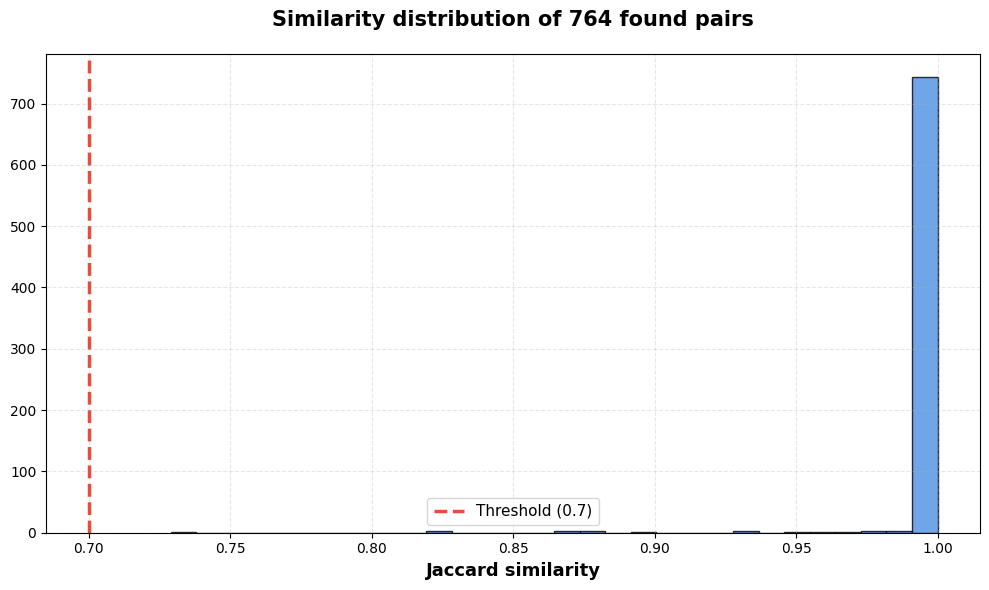

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(results_df['jaccard_similarity'], bins=30, edgecolor='black',
         alpha=0.8, color='#4A90E2')

plt.axvline(x=threshold, color='#E74C3C', linestyle='--', linewidth=2.5,
            label=f'Threshold ({threshold})')

plt.xlabel('Jaccard similarity', fontsize=13, fontweight='bold')
plt.title(f'Similarity distribution of {len(results_df)} found pairs',
          fontsize=15, fontweight='bold', pad=20)

plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

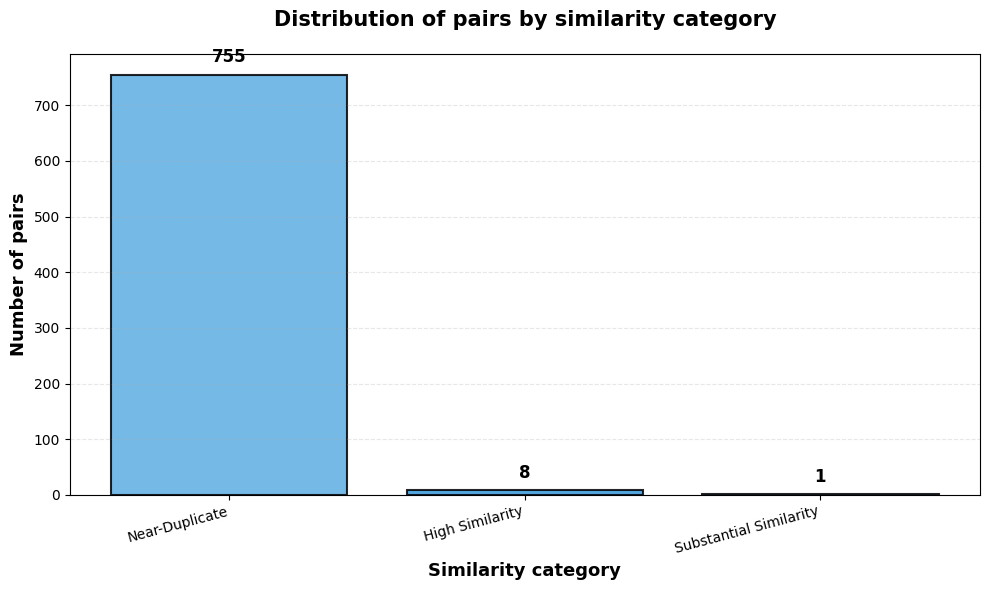

In [ ]:
plt.figure(figsize=(10, 6))

cat_counts = results_df['duplicate_type'].value_counts()
colors_palette = ['#5DADE2', '#3498DB', '#2E86C1']

bars = plt.bar(cat_counts.index, cat_counts.values, edgecolor='black',
               linewidth=1.5, alpha=0.85, color=colors_palette[:len(cat_counts)])

# Add value labels on bars
for i, (idx, value) in enumerate(cat_counts.items()):
    plt.text(i, value + max(cat_counts.values)*0.02, str(value),
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Similarity category', fontsize=13, fontweight='bold')
plt.ylabel('Number of pairs', fontsize=13, fontweight='bold')
plt.title('Distribution of pairs by similarity category', fontsize=15, fontweight='bold', pad=20)
plt.xticks(rotation=15, ha='right')
plt.grid(True, alpha=0.3, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

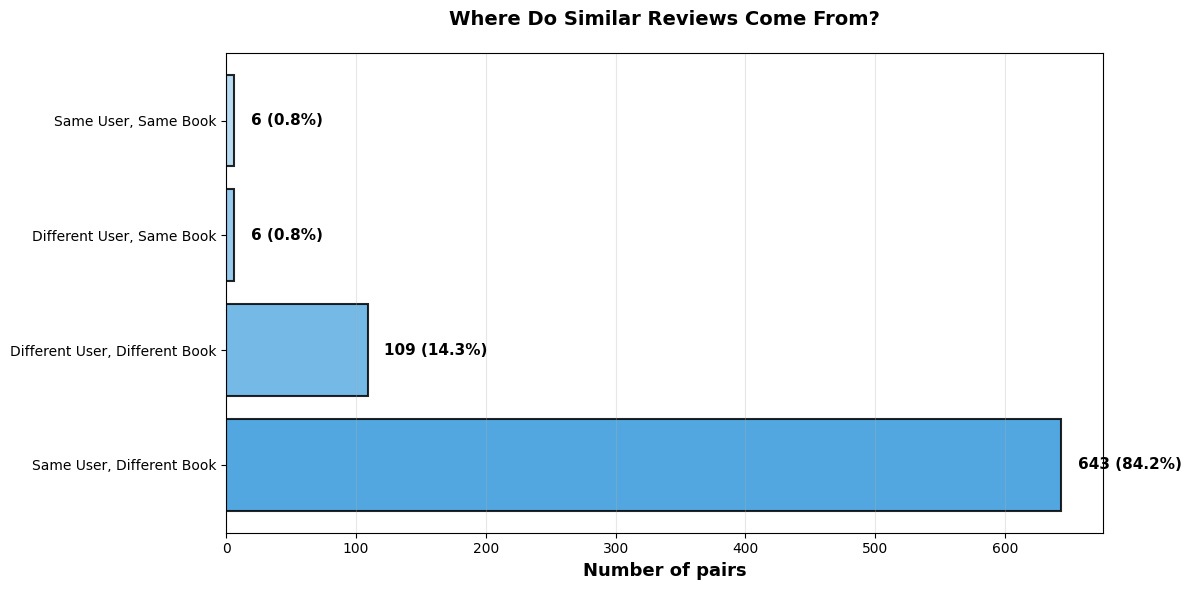

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

rel_counts = results_df['relationship'].value_counts()
colors_rel = ['#3498DB', '#5DADE2', '#85C1E9', '#AED6F1']

bars = ax.barh(rel_counts.index, rel_counts.values, edgecolor='black', linewidth=1.5, alpha=0.85, color=colors_rel[:len(rel_counts)])

for i, (idx, value) in enumerate(rel_counts.items()):
  pct = 100*value/len(results_df)
  ax.text(value + max(rel_counts.values)*0.02, i, f'{value} ({pct:.1f}%)', va='center', fontsize=11, fontweight='bold')

ax.set_xlabel('Number of pairs', fontsize=13, fontweight='bold')
ax.set_title('Where Do Similar Reviews Come From?',
                 fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

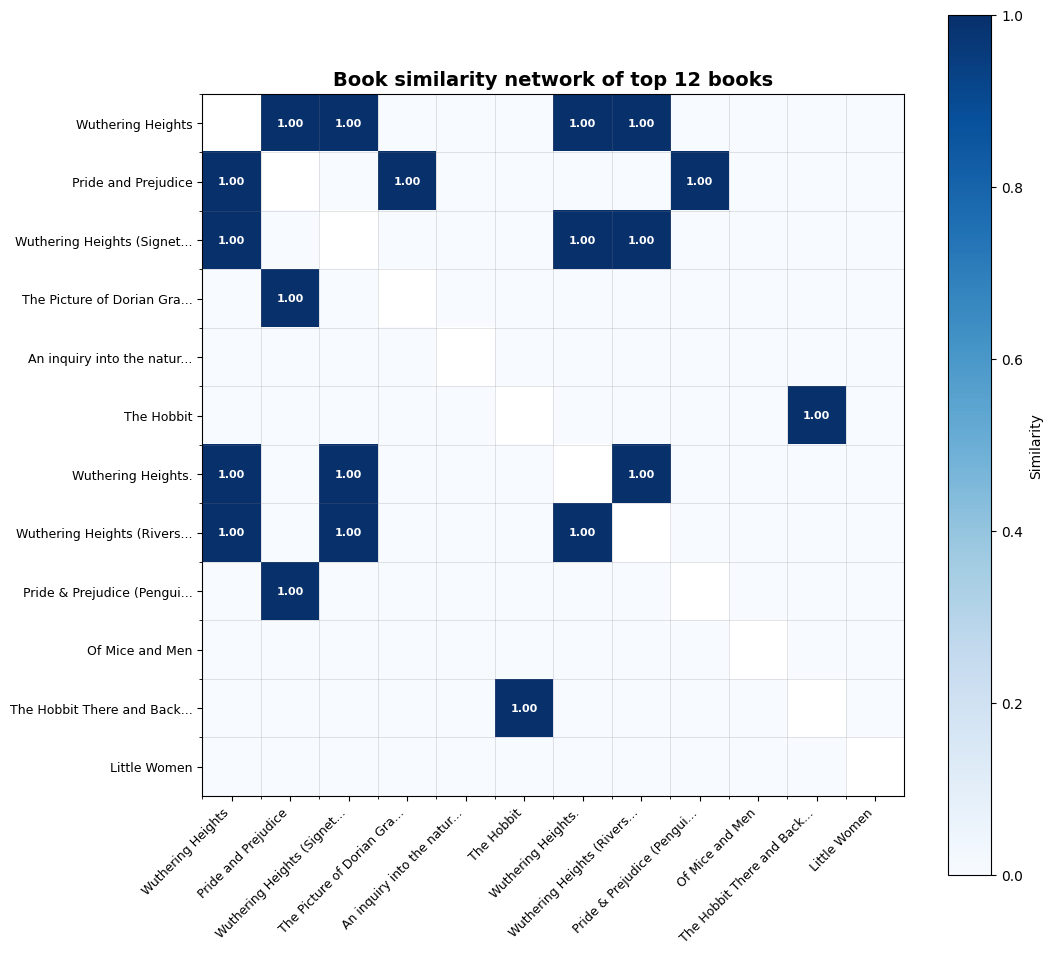

In [ ]:
book_counts = pd.concat([
    results_df['title_1'].value_counts(),
    results_df['title_2'].value_counts()
]).groupby(level=0).sum().sort_values(ascending=False)

top_books = book_counts.head(12).index.tolist()

N = len(top_books)
matrix = np.zeros((N, N))

for _, row in results_df.iterrows():
    if row['title_1'] in top_books and row['title_2'] in top_books:
        i = top_books.index(row['title_1'])
        j = top_books.index(row['title_2'])
        matrix[i, j] = max(matrix[i, j], row['jaccard_similarity'])
        matrix[j, i] = matrix[i, j]

labels = [book[:25] + "..." if len(book) > 25 else book for book in top_books]

fig, ax = plt.subplots(figsize=(11, 10))
np.fill_diagonal(matrix, np.nan)

im = ax.imshow(matrix, cmap='Blues', vmin=0, vmax=1)

ax.set_xticks(range(N))
ax.set_yticks(range(N))
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(labels, fontsize=9)

for i in range(N):
    for j in range(N):
        if i != j and matrix[i, j] > 0:
            color = 'white' if matrix[i, j] > 0.6 else 'black'
            ax.text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center',
                   color=color, fontsize=8, fontweight='bold')

plt.colorbar(im, ax=ax, label='Similarity')
ax.set_title(f'Book similarity network of top {N} books', fontsize=14, fontweight='bold')

ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)
ax.set_xticks(np.arange(N)-.5, minor=True)
ax.set_yticks(np.arange(N)-.5, minor=True)

plt.tight_layout()
plt.show()

This graph shows which specific books have similar reviews.

The matrix shows clear clusters:
* Cluster 1: "Wuthering Heights" editions, where all 4 editions connect to each other
* Cluster 2: "Pride and Prejudice" editions, multiple editions connecting
* Cluster 3: "The Hobbitt", which is connected to "The Hobbit There and Back Again", meaning it's same book, butdifferent title format

Also "Little Women" and "Of Mice and Men" have no connections. It could be due to the fact that these books' similar reviews involve books not in the top 12 or their duplicate patterns are with less-popular books. *Because book is considered a "top book" based on how many times it appears in similar pairs, not based on whether it connects to other books in the top 12.*